<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Подбор-модели" data-toc-modified-id="Подбор-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подбор модели</a></span></li><li><span><a href="#Тест-модели" data-toc-modified-id="Тест-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тест модели</a></span></li></ul></div>

In [1037]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool, cv

## Первичный анализ данных

In [1038]:
#import data
df_train = pd.read_csv('datasets/train.csv')
df_train.index = df_train['Id']
df_test = pd.read_csv('datasets/test.csv')
df_test.index = df_test['Id']

In [1039]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

В датасете очень много признаков, что потенциально может привести к переобучению. Дальнейший план EDA:   
1. Удалить признаки с долей пропусков более 15%
2. Оставить топ признаков по уровню корреляции с целевой переменной
3. Удалить признаки с высокой кросс-корреляцией
4. Обработать пропуски

**Признаки с высокой долей пропусков**

In [1040]:
null_bench = 0.15
null_train = df_train.isnull().sum() / len(df_train) 
null_train = list(null_train[null_train >= null_bench].index)

null_test = df_test.isnull().sum() / len(df_test) 
null_test = list(null_test[null_test >= null_bench].index)

null_train.extend(null_test)
null = list(set(null_train))
null

['FireplaceQu', 'PoolQC', 'Fence', 'LotFrontage', 'MiscFeature', 'Alley']

In [1041]:
#delete columns with high share of null
df_train = df_train.drop(null, axis=1)
df_test = df_test.drop(null, axis=1)

**Анализ корреляции**

In [1042]:
df_train_corr = pd.get_dummies(df_train.dropna(), drop_first=True)
corr = np.abs(df_train_corr.corr()['SalePrice']).sort_values(ascending=False)
corr.head(11)

SalePrice         1.000000
OverallQual       0.783546
GrLivArea         0.711706
GarageCars        0.640154
GarageArea        0.607535
1stFlrSF          0.604714
TotalBsmtSF       0.602042
ExterQual_TA      0.585107
FullBath          0.569313
TotRmsAbvGrd      0.551821
KitchenQual_TA    0.524120
Name: SalePrice, dtype: float64

In [1043]:
corr_with_target_bench = 0.5
corr_across_bench = 0.7

column_set = list(corr[(corr >= corr_with_target_bench) & (corr != 1)].index)
cm = np.abs(df_train_corr[column_set].corr())
ls = []

for i in cm.columns:
    for j in cm.columns:
        if (cm.loc[i, j] >= corr_across_bench) and (cm.loc[i, j] != 1) and ([i, j] not in ls) and ([j, i] not in ls):
            ls.append([i, j])
ls

[['GrLivArea', 'TotRmsAbvGrd'],
 ['GarageCars', 'GarageArea'],
 ['1stFlrSF', 'TotalBsmtSF']]

In [1044]:
ls_remove = []
for pair in ls:
    if corr[pair[0]] > corr[pair[1]]:
        ls_remove.append(pair[1])
    else:
        ls_remove.append(pair[0])
ls_remove

['TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF']

In [1045]:
for el in column_set:
    if el in ls_remove:
        column_set.remove(el)
column_set.append('SalePrice')
column_set

['OverallQual',
 'GrLivArea',
 'GarageCars',
 '1stFlrSF',
 'ExterQual_TA',
 'FullBath',
 'KitchenQual_TA',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

In [1046]:
#delete columns with cross correlation
df_train = pd.get_dummies(df_train)
df_train = df_train[column_set]

In [1047]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   OverallQual     1460 non-null   int64
 1   GrLivArea       1460 non-null   int64
 2   GarageCars      1460 non-null   int64
 3   1stFlrSF        1460 non-null   int64
 4   ExterQual_TA    1460 non-null   uint8
 5   FullBath        1460 non-null   int64
 6   KitchenQual_TA  1460 non-null   uint8
 7   YearBuilt       1460 non-null   int64
 8   YearRemodAdd    1460 non-null   int64
 9   SalePrice       1460 non-null   int64
dtypes: int64(8), uint8(2)
memory usage: 105.5 KB


In [1048]:
#delete columns with cross correlation
column_set.remove('SalePrice')
df_test = pd.get_dummies(df_test)
df_test = df_test[column_set]

In [1049]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OverallQual     1459 non-null   int64  
 1   GrLivArea       1459 non-null   int64  
 2   GarageCars      1458 non-null   float64
 3   1stFlrSF        1459 non-null   int64  
 4   ExterQual_TA    1459 non-null   uint8  
 5   FullBath        1459 non-null   int64  
 6   KitchenQual_TA  1459 non-null   uint8  
 7   YearBuilt       1459 non-null   int64  
 8   YearRemodAdd    1459 non-null   int64  
dtypes: float64(1), int64(6), uint8(2)
memory usage: 94.0 KB


**Обработка пропусков**

Единственный пропуск в новом датасете оказался лишь в переменной GarageCars тестовой выборки. Заменим его на модальное значение.

In [1050]:
df_test['GarageCars'][df_test['GarageCars'] != df_test['GarageCars']] = df_test['GarageCars'].mode()[0]
df_test['GarageCars'] = df_test['GarageCars'].astype('int')

In [1051]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   OverallQual     1459 non-null   int64
 1   GrLivArea       1459 non-null   int64
 2   GarageCars      1459 non-null   int64
 3   1stFlrSF        1459 non-null   int64
 4   ExterQual_TA    1459 non-null   uint8
 5   FullBath        1459 non-null   int64
 6   KitchenQual_TA  1459 non-null   uint8
 7   YearBuilt       1459 non-null   int64
 8   YearRemodAdd    1459 non-null   int64
dtypes: int64(7), uint8(2)
memory usage: 94.0 KB


## Исследовательский анализ данных

**SalePrice**

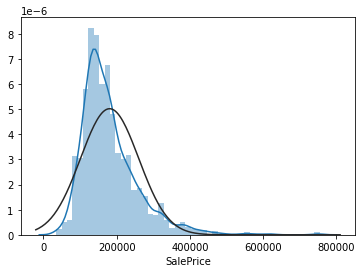

In [1052]:
sns.distplot(df_train['SalePrice'] , fit=norm);

In [1053]:
print(f'Skewness: {df_train["SalePrice"].skew():.2f}')
print(f'Kurtosis: {df_train["SalePrice"].kurt():.2f}')

Skewness: 1.88
Kurtosis: 6.54


**Вывод**   
Распределение целевой переменной имеет положительное смещение относительно нормального, а также является более пиковым. Логарифмирование переменной поможет приблизить распределение к нормальному.

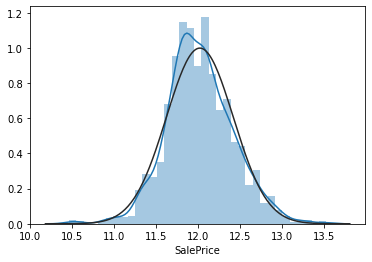

In [1054]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);

In [1055]:
print(f'Skewness: {df_train["SalePrice"].skew():.2f}')
print(f'Kurtosis: {df_train["SalePrice"].kurt():.2f}')

Skewness: 0.12
Kurtosis: 0.81


**Проверка на соответствие нормальному распределению**

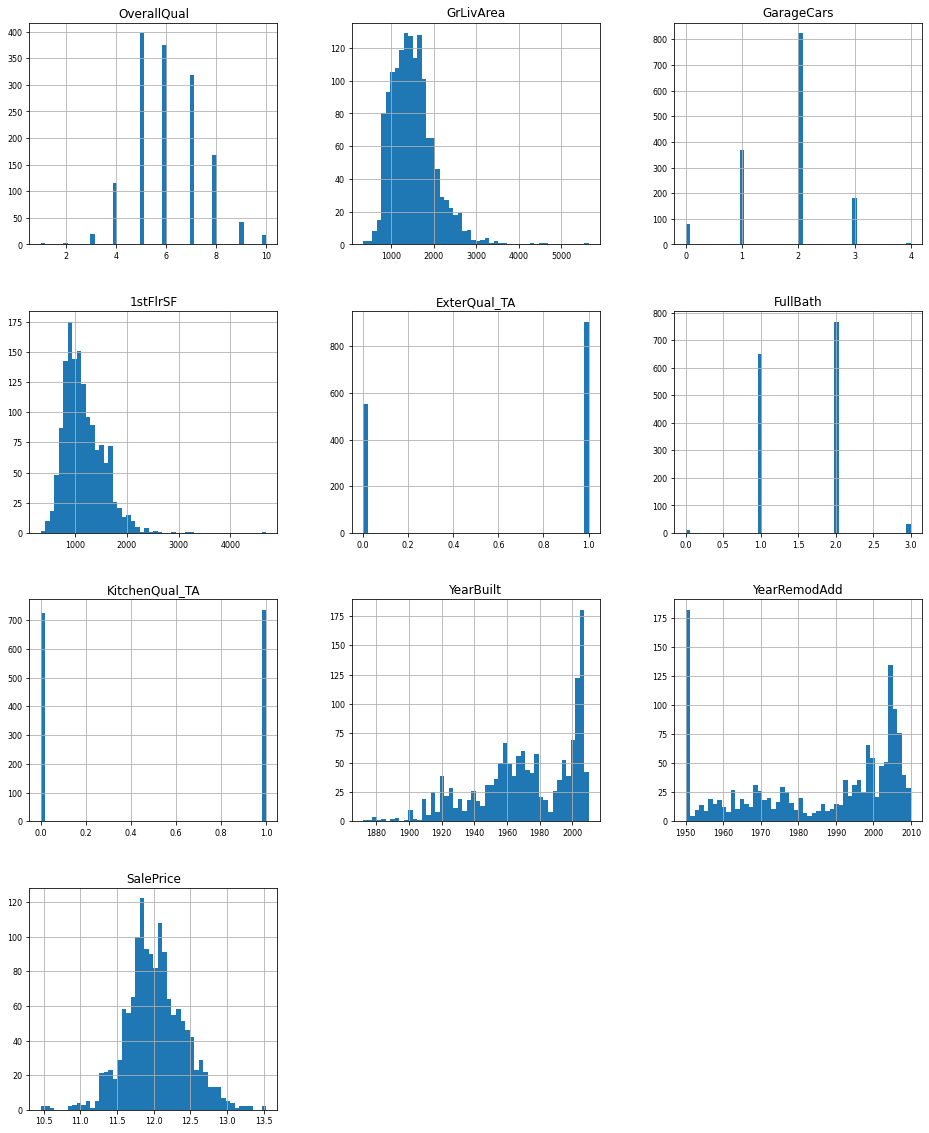

In [1056]:
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Переменные GrLiveArea, 1stFlrSf также имеют позитивное смещение. Применим к ним log-преобразование.

In [1057]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

df_train['1stFlrSF'] = np.log(df_train['1stFlrSF'])
df_test['1stFlrSF'] = np.log(df_test['1stFlrSF'])

Обратим внимание, что переменная YearRemodAdd имеет большое число наблюдений за 1950 год, что потенциально может означать все годы до этого периода. Для получения более устойчивой модели исключим данную переменную из анализа.

In [1058]:
df_train = df_train.drop(['YearRemodAdd'], axis=1)
df_test = df_test.drop(['YearRemodAdd'], axis=1)

**Поиск выбросов**

In [1059]:
features = df_train.drop(['SalePrice'], axis=1)

In [1060]:
ls = list(features.columns)
ls

['OverallQual',
 'GrLivArea',
 'GarageCars',
 '1stFlrSF',
 'ExterQual_TA',
 'FullBath',
 'KitchenQual_TA',
 'YearBuilt']

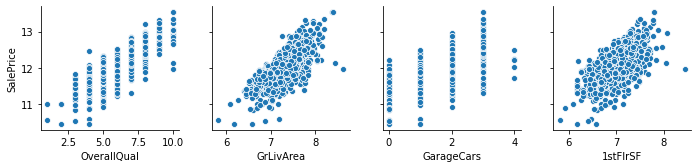

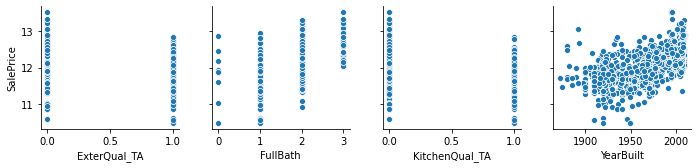

In [1061]:
for i in range(0, len(df_train.columns)-1, 4):
    sns.pairplot(data=df_train,
                x_vars=df_train.columns[i:i+4],
                y_vars=['SalePrice'])

**Вывод**   
Исходя из анализа, нужно удалить следующие комбинации наблюдений:
1. OverallQual < 5 & SalePrice > 12.3
2. GrLivArea > 8.2 & Saleprice < 12.2
3. 1stFlrSF > 8.2
4. YearBuilt < 1900 & SalePrice > 12.2

In [1062]:
ls = []
ls.extend(list(df_train[(df_train['OverallQual'] < 5) & (df_train['SalePrice'] > 12.3)].index))
ls.extend(list(df_train[(df_train['GrLivArea'] > 8.2) & (df_train['SalePrice'] < 12.2)].index))
ls.extend(list(df_train[df_train['1stFlrSF'] > 8.2].index))
ls.extend(list(df_train[(df_train['YearBuilt'] < 1900) & (df_train['SalePrice'] > 12.2)].index))
ls = list(set(ls))
ls

[584, 458, 524, 748, 305, 1299, 186]

In [1063]:
df_train = df_train[~df_train.index.isin(ls)]
df_train = df_train.reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OverallQual     1453 non-null   int64  
 1   GrLivArea       1453 non-null   float64
 2   GarageCars      1453 non-null   int64  
 3   1stFlrSF        1453 non-null   float64
 4   ExterQual_TA    1453 non-null   uint8  
 5   FullBath        1453 non-null   int64  
 6   KitchenQual_TA  1453 non-null   uint8  
 7   YearBuilt       1453 non-null   int64  
 8   SalePrice       1453 non-null   float64
dtypes: float64(3), int64(4), uint8(2)
memory usage: 82.4 KB


## Подбор модели

In [1064]:
X_train = df_train.drop(['SalePrice'], axis=1)
y = df_train['SalePrice']
X_test = df_test
X_train.shape, y.shape, X_test.shape

((1453, 8), (1453,), (1459, 8))

In [1065]:
def estimate(model, X, y):
    rmse = np.sqrt(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')*(-1)).mean()
    r2 = np.sqrt(cross_val_score(model, X, y, cv=5, scoring='r2')).mean()
    print(f'RMSE - {rmse:.2f}')
    print(f'R2 - {r2:.2f}')

In [1066]:
#linear regression
model = LinearRegression()
estimate(model, X_train, y)

RMSE - 0.16
R2 - 0.92


In [1067]:
#ridge regression
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
min_score = 100
for x in alphas:
    model = Ridge(alpha=x)
    rmse = np.sqrt(cross_val_score(model, X_train, y, cv=5, scoring='neg_mean_squared_error')*(-1)).mean()
    if rmse < min_score:
        min_score = rmse
        best_alpha = x

model = Ridge(alpha=best_alpha)
estimate(model, X_train, y)

RMSE - 0.16
R2 - 0.92


In [1068]:
#lasso regression
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
min_score = 100
for x in alphas:
    model = Lasso(alpha=x)
    rmse = np.sqrt(cross_val_score(model, X_train, y, cv=5, scoring='neg_mean_squared_error')*(-1)).mean()
    if rmse < min_score:
        min_score = rmse
        best_alpha = x

model = Lasso(alpha=best_alpha)
estimate(model, X_train, y)

RMSE - 0.17
R2 - 0.91


In [1075]:
#CatBoostRegressor
cv_dataset = Pool(data=X_train, label=y)

params = {
    'loss_function': 'RMSE',
    'random_state': 7,
    'verbose': 0,
    'eval_metric' : 'RMSE',
    }

scores = cv(cv_dataset, params, fold_count=5, logging_level='Silent', as_pandas=True)
score = scores['train-RMSE-mean'].min()
print(f'RMSE - {score:.2f}')

RMSE - 0.10


## Тест модели

In [1070]:
model = CatBoostRegressor(**params)
model.fit(X_train, y)
pred = np.exp(model.predict(X_test))

In [1071]:
df = pd.DataFrame(pred, index=df_test.index)
df.columns = ['SalePrice']